# Pine Labs

In [31]:
# Load necessary libraries
import sys
import warnings
warnings.filterwarnings('ignore')
import datetime
import pandas as pd
import gensim
import tqdm.notebook as tqdm
from tqdm.auto import tqdm
tqdm.pandas()

sys.path.append('/Users/pushkar/Documents/projects/fin_comp/comp/docs')

import utils.helper
from utils.helper import Processor
import importlib
importlib.reload(utils.helper)

import plotly.io as pio
svg_renderer = pio.renderers["svg"]
svg_renderer.width = 900
svg_renderer.height = 500
pio.renderers.default = "svg"
import plotly.express as px

In [2]:
# Load data
df = pd.read_csv('./../../data/fintech/pine_labs/pine_labs.csv')

In [4]:
# Company username
company_username = 'PineLabs'

In [5]:
# Correct the format of variables
df['inReplyToTweetId'] = df['inReplyToTweetId'].apply(lambda x: '%.0f' % x).values.tolist()
df['conversation_id'] = df['conversation_id'].astype(str)

In [6]:
# Declare the query words
query_words = ['dm', 'customer experience', 'inconvenience', 'concern team', 'resolve', 
                'solve', 'no noc', 'await response', 'unpleasant experience']

In [7]:
# Declare the processor object
processor = Processor('./../../data/config.json')

In [8]:
# Check whether an observation is query for the company or not
df['is_query'] = 0

for word in tqdm(query_words):
    df['is_query'] = df['is_query'] + df['tweet'].apply(processor.word_distribution, find=word).astype(int)

  0%|          | 0/9 [00:00<?, ?it/s]

In [9]:
# Select observations of queries
qdf = df[(df['is_query']>0) & (df['username'] == company_username)]

In [10]:
qdf.shape

(511, 28)

In [11]:
# Get all the conversation ids
conversation_ids = qdf['conversation_id'].unique()
print(f"Total number of unique conversations: {len(conversation_ids)}")

Total number of unique conversations: 468


In [12]:
df['date'] = pd.to_datetime(df['date'])

## Response time

Response time is the time the company takes to respond to the first query.

In [13]:
result = pd.DataFrame()
result['conversation_id'] = conversation_ids
result['response_time'] = 0

In [14]:
for index, conversation_id in enumerate(conversation_ids):
    tmp = df[df['conversation_id'] == conversation_id]
    tmp.sort_values('date', ascending=True, inplace=True)
    comp_tmp = tmp[tmp['username'] == company_username]
    response_time = (comp_tmp.iloc[0]['date'] - tmp.iloc[0]['date']) / datetime.timedelta(hours=1)
    result.at[index, 'response_time'] = response_time

In [15]:
result

,conversation_id,response_time
0,1342432402510143490,0.496667
1,1343827514469191681,0.000000
2,1343806828421861377,0.600833
3,1343814255330541571,0.102222
4,1343472138779443202,0.000000
...,...,...
463,1084764264265437184,2.525556
464,1084103141589565440,0.000000
465,1080406875424911360,0.000000
466,1082519608081436672,6.013889


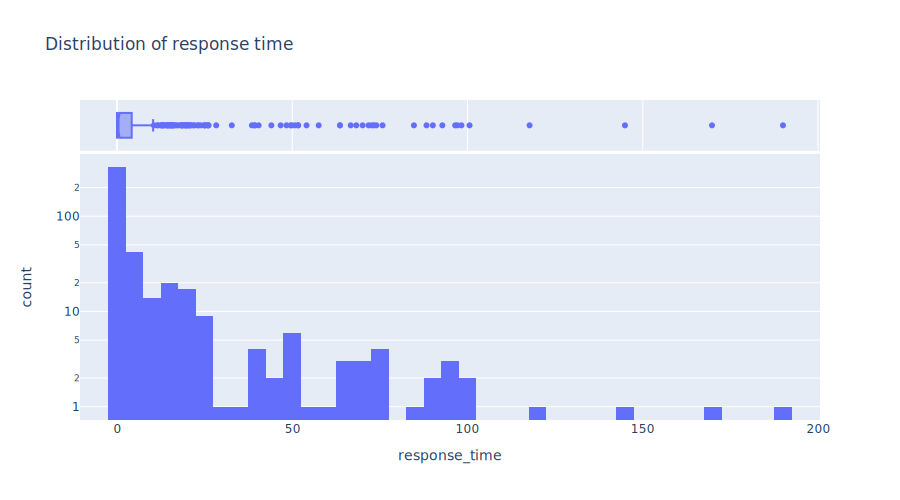

In [18]:
fig = px.histogram(result[result['response_time']<1000], x='response_time', log_y=True, marginal='box', title='Distribution of response time')
fig.show()

## Resolution time

Assuming that if the last query in the conversation is from the company then the issue is resolved.  
Resolution time is the time difference between the last date of last tweet in the conversation and the date of first query.

In [19]:
result['resolution_time'] = 0

In [20]:
for index, conversation_id in enumerate(conversation_ids):
    tmp = df[df['conversation_id'] == conversation_id]
    tmp.sort_values('date', ascending=True, inplace=True)
    comp_tmp = tmp[tmp['username'] == company_username]
    if tmp.iloc[-1]['username'] == company_username:
        resolution_time = (tmp.iloc[-1]['date'] - tmp.iloc[0]['date']) / datetime.timedelta(hours=1)
        result.at[index, 'resolution_time'] = resolution_time

In [21]:
print(f"Number of queries resolved: {len(result['resolution_time'].to_numpy().nonzero()[0])}")
print(f"Number of queries unresolved: {result.shape[0] - len(result['resolution_time'].to_numpy().nonzero()[0])}")

Number of queries resolved: 288
Number of queries unresolved: 180


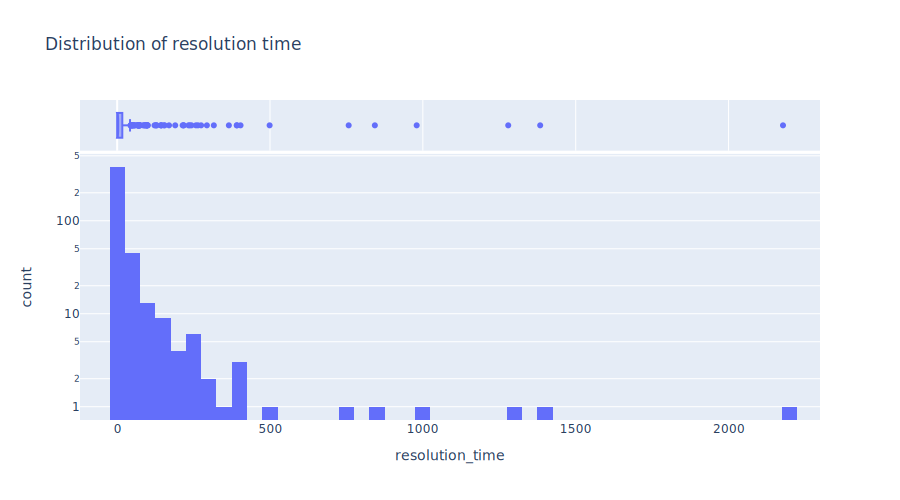

In [25]:
fig = px.histogram(result[result['resolution_time']<3000], x='resolution_time', log_y=True, marginal='box', title='Distribution of resolution time')
fig.show()

In [26]:
result.describe()

,response_time,resolution_time
count,468.000000,468.000000
mean,11.482594,64.629625
std,62.884684,573.200856
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.442778,0.754444
75%,4.286528,17.082917
max,1279.305278,11950.471389


## Query Tweets Topics


In [27]:
queries = df[df['conversation_id'].isin(conversation_ids)]
queries.sort_values('date', ascending=True, inplace=True)
queries = queries[queries['inReplyToTweetId'] == 'nan']
queries.shape


(391, 28)

In [32]:
processor = Processor('./../../data/config.json')
queries = processor.preprocess_individual(queries)
id2word = gensim.corpora.Dictionary(queries['bigram'].values.tolist())
corpus = [id2word.doc2bow(text) for text in queries['bigram'].values.tolist()]


In [33]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                        id2word=id2word,
                                        num_topics=4,
                                        random_state=100,
                                        chunksize=100,
                                        passes=10,
                                        per_word_topics=True,
                                        alpha=0.3,
                                        eta=0.3)
coherence_model = gensim.models.CoherenceModel(model=lda_model, 
                                                    texts=queries['bigram'].values.tolist(), 
                                                    dictionary=id2word, 
                                                    coherence='u_mass')
coherence_model_score = coherence_model.get_coherence()
print('Coherence Score: ', coherence_model_score)
import pyLDAvis.gensim_models

import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared


Coherence Score:  -8.617124205758271


/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/en

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.016130 -0.098853       1        1  30.099643
0     -0.062815  0.012631       2        1  30.070574
1      0.091282  0.045873       3        1  20.149493
2     -0.044597  0.040349       4        1  19.680290, topic_info=            Term       Freq      Total Category  logprob  loglift
243  transaction  17.000000  17.000000  Default  30.0000  30.0000
84       service  56.000000  56.000000  Default  29.0000  29.0000
30      response  23.000000  23.000000  Default  28.0000  28.0000
69       working  17.000000  17.000000  Default  27.0000  27.0000
301          hai   6.000000   6.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
72          help   4.013090  17.569043   Topic4  -5.4527   0.1490
83        people   3.454769  11.168938   Topic4  -5.6025   0.4522
580       person   3.030834   7.742851   Topic4  -5.7334   0.6876
32         sales   3.375811  20.851724   Topic4  -5.6256  -0.1952
111        money   3.221814  18.134772   Topic4  -5.6723  -0.1023

[294 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
39        2  0.362647        able
39        3  0.120882        able
39        4  0.483529        able
1155      4  0.468718  acceptance
116       1  0.136849     account
...     ...       ...         ...
69        4  0.453432     working
207       1  0.178886       worst
207       2  0.417400       worst
207       3  0.119257       worst
207       4  0.298143       worst

[467 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3])

In [34]:
queries_topic_sents_keywords = processor.dominant_topics(ldamodel=lda_model, 
                                                         corpus=corpus, 
                                                         texts=queries['bigram'].values.tolist(),
                                                         tweets=queries['tweet'].values.tolist())
queries_topic_sents_keywords['Topic_Keywords'].unique()


array(['machine, response, working, month, service, company, issue, pos, months, worst',
       'service, payment, days, received, account, team, machine, customer, complaint, know',
       'machine, pos, service, payment, team, response, days, sales, ur, business',
       'machine, transaction, days, pos, hai, payment, money, account, business, rt_answer'],
      dtype=object)

In [35]:
select = queries_topic_sents_keywords['Topic_Keywords'].unique()[1]
queries_topic_sents_keywords[queries_topic_sents_keywords['Topic_Keywords'] == select]['Text'].values


array(['Did you know that you can now offer easy EMIs on debit cards?\nDelight your customers with our affordability solutions. Read more at https://t.co/4dYhh0cNZf\n#DebitEMI #payment #pinelabs',
       "@PineLabs your sale's man are not transparent and does fake promises. your service is worthless piece of shit. I regret that i chose your service.i should have chosen @BajajFinCorp instead of your service.",
       "@PineLabs worst service , no support\nPayment done 45 days ago but POS terminal yet not installed\n\nNobody is picking up the phone call also at Toll free they can't take complaint as there is no TID as of now.\n\nGot fed up with you people.",
       '@PineLabs i m from tunmarg aircon Indore(M P) my swipe machine is not working from last three month ur sumeet makwana 📱9907650650 know that but no one give resolution &amp; rental deduct every month why ?\nJust take machine &amp; give my payment back \nCall back ASAP\n9827788674\n9036699339',
       'Our focus is on increasin

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



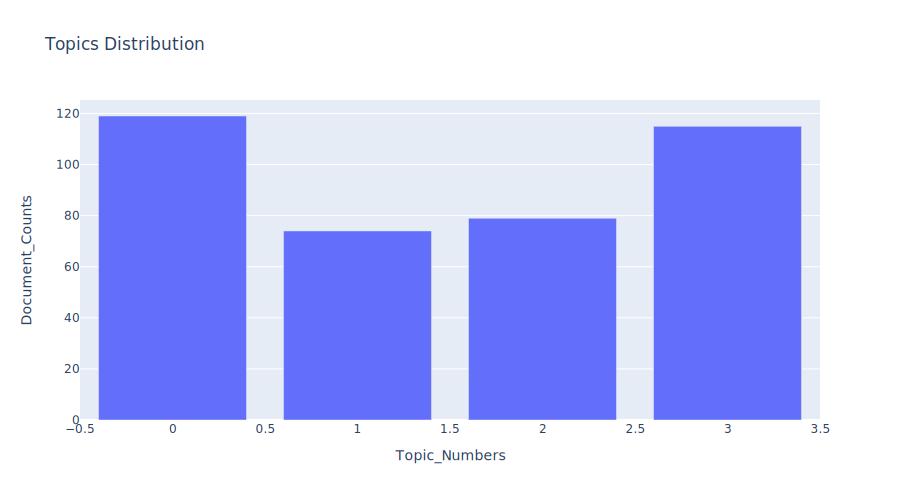

In [36]:
queries_dist, fig = processor.plot_topic_distribution(queries_topic_sents_keywords)
fig.show()